In [1]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

True


# Overview

Can a computer "learn" to classify artists by their paintings? 

ResNet50 is a good model for classifying ImageNet data. How about a set of 38 artists?

We use transfer learning to re-train a ResNet50 model to identify one of 38 artists who have more than ***200*** paintings in the dataset. 

This notebook is part of a project for CSC 480 taught by [Dr. Franz J. Kurfess](http://users.csc.calpoly.edu/~fkurfess/) at Cal Poly

A web application is [in development](https://github.com/SomethingAboutImages/WebImageClassifier) to make use of the model that this notebook outputs. 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [3]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
# %pip freeze > frozen-requirements.txt
# append system information to file
# with open("frozen-requirements.txt", "a") as file:
#     file.write(sys_info())

{'commit_hash': '4e1d3e557',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': 'C:\\Users\\aluce\\anaconda3\\Lib\\site-packages\\IPython',
 'ipython_version': '8.12.3',
 'os_name': 'nt',
 'platform': 'Windows-10-10.0.22621-SP0',
 'sys_executable': 'c:\\Users\\aluce\\anaconda3\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit '
                '(AMD64)]'}


In [4]:
# %pip install -r "C:\Users\jesus\Desktop\Projecte\XNAPproject-grup07\our_code\frozen-requirements.txt" 

# %pip install -r '/home/xnmaster/Project/XNAPproject-grup07/our_code/frozen-requirements.txt'

In [5]:
# %pip install tensorflow[and-cuda]

In [6]:
# %pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

In [7]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10192695110379961881
xla_global_id: -1
]


In [8]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [9]:
# %pip install Pillow --upgrade

In [10]:
DATA_DIR = r"C:\Users\jesus\Desktop\Projecte"
TRAIN_1_DIR = r"C:\Users\jesus\Desktop\Projecte\train_10_selected_artists-20240525T170033Z-001\train_10_selected_artists"
#TRAIN_2_DIR = r"C:\Users\jesus\Desktop\Projecte\imatges\train_9\train_9"


TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
TEST_DIR = r"C:\Users\jesus\Desktop\Projecte\test"

In [11]:
# globals

DATA_DIR = '/home/xnmaster/Pictures'
TRAIN_1_DIR = '/home/xnmaster/Pictures/train_10_artists/train_10_artists'

TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
TEST_DIR = "/home/xnmaster/Pictures/test"

In [18]:
# globals

DATA_DIR = '../../'
TRAIN_1_DIR = '../../train_10_selected_artists'

TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
TEST_DIR = "../../test"

Execute in local and virtual
(no cal cada vegada, només una vegada pq elimina les fotos que no són vàlides)

In [19]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 3886
Number of files in the folder TEST_DIR: 61


After augmentation

In [20]:
df = pd.read_csv('../../all_data_info.csv') # r'\train_info\train_info.csv'
print("df.shape", df.shape)

df.shape (103250, 12)


In [21]:
df = pd.read_csv(DATA_DIR + 'all_data_info.csv')
print("df.shape", df.shape)

df.shape (103250, 12)


In [22]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [23]:
# quick fix for corrupted files
list_of_corrupted = ['3917.jpg','18649.jpg','20153.jpg','41945.jpg',
'79499.jpg','91033.jpg','92899.jpg','95347.jpg',
'100532.jpg','101947.jpg']
# display the corrupted rows of dataset for context
corrupt_df = df[df["new_filename"].isin(list_of_corrupted) == True]
print(corrupt_df.head(len(list_of_corrupted)))

# completely get rid of them
df = df[df["new_filename"].isin(list_of_corrupted) == False]

# try to see if they are still there
print(df[df["new_filename"].isin(list_of_corrupted) == True])

print("df.shape", df.shape)

                             artist    date              genre  pixelsx  \
185                  Giorgio Vasari    1534           portrait   3512.0   
731                       Juan Gris    1918          cityscape   2844.0   
994                       Juan Gris    1917         still life   3918.0   
1084   John Roddam Spencer Stanhope    1860     genre painting   4249.0   
1105                 Henri Rousseau    1908          cityscape   3403.0   
9984   John Roddam Spencer Stanhope     NaN  symbolic painting   1309.0   
19876              Georgia O'Keeffe  1915.0           abstract   1400.0   
28748                    Franz Marc    1913    animal painting    951.0   
46256           Esaias van de Velde    1622          landscape    942.0   
98236                 George Inness     NaN  literary painting    376.0   

       pixelsy  size_bytes     source                         style  \
185     4850.0  10360549.0    wikiart  Mannerism (Late Renaissance)   
731     3882.0   5393504.0    wi

Keep the works of artists who have a representation above 50%

In [24]:
# Step 1: Count occurrences of each artist
artist_counts = df['artist'].value_counts()

Artists

In [25]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

test_df.shape (23814, 2)
train_df.shape (103240, 2)


In [26]:
artists = {'Camille Pissarro': 393,
 'Vincent van Gogh': 392,
 'Theophile Steinlen': 389,
 'Pierre-Auguste Renoir': 388,
 'Boris Kustodiev': 388,
 'Pyotr Konchalovsky': 388,
 'Gustave Dore': 387,
 'Edgar Degas': 387,
 'Camille Corot': 387,
 'Eugene Boudin': 387
}

In [27]:
training_set_artists = list(artists.keys())
training_set_artists

['Camille Pissarro',
 'Vincent van Gogh',
 'Theophile Steinlen',
 'Pierre-Auguste Renoir',
 'Boris Kustodiev',
 'Pyotr Konchalovsky',
 'Gustave Dore',
 'Edgar Degas',
 'Camille Corot',
 'Eugene Boudin']

In [28]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,new_filename
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
147,Edgar Degas,95360.jpg
279,Pierre-Auguste Renoir,85018.jpg


In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# specify the model that classifies 38 artists 🎨 🖌

## wandb
Execute following lines if we use wandb

In [30]:
# %pip install wandb -qU

In [31]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

#wandb.login(relogin=True)

# 0927244f833ccea1b247099feaaaf54084a5c30c

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1608667 (xarxes_projecte). Use `wandb login --relogin` to force relogin


True

## without wandb

In [32]:
len(training_set_artists)

10

In [33]:
from tensorflow.keras import regularizers

class AdaptiveKernelRegularizer(regularizers.Regularizer):
    def __init__(self, initial_lambda=0.01, growth_rate=0.001):
        self.initial_lambda = initial_lambda
        self.growth_rate = growth_rate
        self.current_lambda = initial_lambda

    def __call__(self, x):
        regularization = self.current_lambda * tensorflow.reduce_sum(tensorflow.square(x))
        self.current_lambda += self.growth_rate  # Update the lambda adaptively
        return regularization

    def get_config(self):
        return {'initial_lambda': self.initial_lambda, 'growth_rate': self.growth_rate}


In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMAGE_SIZE = 224
num_classes = len(training_set_artists)

# Define the base model with ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


# Build the model
model_adam = Sequential()
model_adam.add(base_model)
model_adam.add(GlobalAveragePooling2D())
model_adam.add(Dense(2048, activation='relu'))  # Aumentar el tamaño de la capa densa
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.0005)))  # Aumentar el tamaño de la capa densa y reducir L2 regularization
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(num_classes, activation='softmax'))


# Compile the model
# model_adam.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Display the model summary
# model_adam.summary()


In [35]:
import tensorflow as tf

class AdaptiveLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.01, factor=0.1, min_lr=1e-6):
        super(AdaptiveLearningRateScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.factor = factor
        self.min_lr = min_lr
        self.last_val_acc = 0
        self.lr = initial_lr
        self.epoch_accuracy = []
        self.learning_rates = [initial_lr]

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None:
            self.epoch_accuracy.append(current_val_acc)
            if current_val_acc < self.last_val_acc:
                if self.lr > self.min_lr:
                    self.lr = max(self.lr * self.factor, self.min_lr)
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.lr)
                    print(f"\nEpoch {epoch+1}: reducing learning rate to {self.lr}.")
            self.learning_rates.append(self.lr)
        else:
            self.learning_rates.append(self.lr)
            
        self.last_val_acc = current_val_acc
        print(f"\nEpoch {epoch+1}: Learning rate is {self.lr}.")

# Crear una instància del callback
adaptive_lr_scheduler = AdaptiveLearningRateScheduler()

In [36]:
opti = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model_adam.compile(
  optimizer=opti, # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)
model_adam.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2

# Compile Model

## Adam

**Observation**
para un problema de clasificación binaria, a menudo se utiliza la 'entropía cruzada binaria', mientras que la 'entropía cruzada categórica' se utiliza para la clasificación de clases múltiples.
https://www.sourcetrail.com/es/pit%C3%B3n/keras/modelo-compilar-keras/

# Setup the image data generator for each training directory 

In [37]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)

Number of files in the folder TRAIN_1_DIR: 3886
Number of files in the folder TEST_DIR: 61


In [38]:
def batch_size(num_fitxers, max_batch_size=64):
    for size in range(max_batch_size, 0, -1):
        if num_fitxers % size == 0:
            return size
    return 1 

BATCH_SIZE = batch_size(num_files_in_train)
TEST_BATCH_SIZE = batch_size(num_files_in_test)

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"TEST_BATCH_SIZE: {TEST_BATCH_SIZE}")


BATCH_SIZE: 58
TEST_BATCH_SIZE: 61


In [39]:
# model globals
IMAGE_SIZE = 224
VAL_SPLIT = 0.25

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

def setup_generators_with_augmentation(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-" * 20)
    if not preprocess_input:
        raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # Stratified split to ensure each class is represented in both sets
    train_df, valid_df = train_test_split(
        train_dataframe,
        test_size=val_split,
        stratify=train_dataframe['artist'],
        random_state=my_seed
    )

    print(len(train_df), "images in the training set")
    print(len(valid_df), "images in the validation set")

    # Check number of images per author in training and validation sets
    print("\nNumber of images per author in the training set:")
    print(train_df['artist'].value_counts())

    print("\nNumber of images per author in the validation set:")
    print(valid_df['artist'].value_counts())

    # Data augmentation for training set
    train_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation and test sets
    valid_test_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    print("\nTraining set ImageDataGenerator with augmentation")
    train_gen = train_data_gen.flow_from_dataframe(
        dataframe=train_df.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nValidation set ImageDataGenerator")
    valid_gen = valid_test_data_gen.flow_from_dataframe(
        dataframe=valid_df.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size, img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\nTest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(),
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False,
        class_mode=None,
        target_size=(img_size, img_size)
    )

    return train_gen, valid_gen, test_gen

In [41]:
print("defined setup_generators_with_augmentation()")
train_gens = [None]
valid_gens = [None]
test_gen = None  # only 1 test_gen

i = 0
for i in range(0, 1):
    train_gens[i], valid_gens[i], test_gen = setup_generators_with_augmentation(
        train_dataframe=t_df,
        train_dir=TRAIN_DIRS[0],
        val_split=VAL_SPLIT,
        img_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        my_seed=MY_SEED,
        list_of_classes=training_set_artists,
        test_dataframe=test_df,
        test_dir=TEST_DIR,
        test_batch_size=TEST_BATCH_SIZE
    )


defined setup_generators_with_augmentation()
--------------------
3715 images in the training set
1239 images in the validation set

Number of images per author in the training set:
Gustave Dore             375
Pierre-Auguste Renoir    375
Pyotr Konchalovsky       374
Camille Pissarro         374
Boris Kustodiev          373
Eugene Boudin            372
Vincent van Gogh         371
Edgar Degas              371
Camille Corot            366
Theophile Steinlen       364
Name: artist, dtype: int64

Number of images per author in the validation set:
Pyotr Konchalovsky       125
Gustave Dore             125
Pierre-Auguste Renoir    125
Camille Pissarro         125
Boris Kustodiev          125
Eugene Boudin            124
Edgar Degas              124
Vincent van Gogh         123
Camille Corot            122
Theophile Steinlen       121
Name: artist, dtype: int64

Training set ImageDataGenerator with augmentation
Found 2918 validated image filenames belonging to 10 classes.


c:\Users\aluce\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 797 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(



Validation set ImageDataGenerator
Found 968 validated image filenames belonging to 10 classes.


c:\Users\aluce\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 271 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(



Test set ImageDataGenerator
Found 61 validated image filenames.


c:\Users\aluce\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 23753 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [42]:
MAX_EPOCHS =  8 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [43]:
MAX_EPOCHS

8

In [44]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [45]:
class AdaptiveLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.01, factor=0.1, min_lr=1e-6):
        super(AdaptiveLearningRateScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.factor = factor
        self.min_lr = min_lr
        self.last_val_acc = 0
        self.lr = initial_lr
        self.epoch_accuracy = []
        self.learning_rates = [initial_lr]

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None:
            self.epoch_accuracy.append(current_val_acc)
            if current_val_acc < self.last_val_acc:
                if self.lr > self.min_lr:
                    self.lr = max(self.lr * self.factor, self.min_lr)
                    self.model.optimizer.learning_rate = self.lr
                    print(f"\nEpoch {epoch+1}: reducing learning rate to {self.lr}.")
            self.learning_rates.append(self.lr)
        else:
            self.learning_rates.append(self.lr)
            
        self.last_val_acc = current_val_acc
        # print(f"\nEpoch {epoch+1}: Learning rate is {self.lr}.")
        # Log the learning rate to wandb
        #wandb.log({"learning_rate": self.lr}, commit=False)




In [46]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Define constants
IMAGE_SIZE = 224
num_classes = len(training_set_artists)

# Define the base model with ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze all layers in the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model_adam = Sequential()
model_adam.add(base_model)
model_adam.add(GlobalAveragePooling2D())
model_adam.add(Dense(2048, activation='relu'))
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.0005)))
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(num_classes, activation='softmax'))

# Compile the model
opti = Adam(learning_rate=0.001)
model_adam.compile(
    optimizer=opti,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
adaptive_lr_scheduler = AdaptiveLearningRateScheduler()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model with frozen layers
initial_epochs = 10
histories_adam50 = []

for i in range(len(train_gens)):
    STEP_SIZE_TRAIN = train_gens[i].n // train_gens[i].batch_size
    STEP_SIZE_VALID = valid_gens[i].n // valid_gens[i].batch_size

    history = model_adam.fit(
        train_gens[i],
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=valid_gens[i],
        validation_steps=STEP_SIZE_VALID,
        epochs=initial_epochs,
        callbacks=[adaptive_lr_scheduler, early_stopping, reduce_lr]
    )
    histories_adam50.append(history)

# Function to unfreeze layers in blocks
def unfreeze_by_blocks(model, base_model, block_size):
    layer_indices = list(range(len(base_model.layers)))
    for i in range(0, len(layer_indices), block_size):
        block_end = min(i + block_size, len(layer_indices))
        for layer_index in layer_indices[i:block_end]:
            base_model.layers[layer_index].trainable = True

        # Recompile the model with a lower learning rate
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
        
        fine_tune_epochs = 5
        for j in range(len(train_gens)):
            STEP_SIZE_TRAIN = train_gens[j].n // train_gens[j].batch_size
            STEP_SIZE_VALID = valid_gens[j].n // valid_gens[j].batch_size

            history = model_adam.fit(
                train_gens[j],
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=valid_gens[j],
                validation_steps=STEP_SIZE_VALID,
                epochs=fine_tune_epochs,
                callbacks=[adaptive_lr_scheduler, early_stopping, reduce_lr]
            )
            histories_adam50.append(history)

        print(f"Unfreezed layers from {i} to {block_end}")

# Unfreeze the model in blocks of 20 layers
block_size = 20
unfreeze_by_blocks(model_adam, base_model, block_size)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_adam.evaluate(valid_gens[0], steps=valid_gens[0].n // valid_gens[0].batch_size)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

# Evaluate the model on the test set
test_loss, test_accuracy = model_adam.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10
50/50 [==============================] - 470s 9s/step - loss: 2.3760 - accuracy: 0.5717 - val_loss: 2.4169 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 383s 8s/step - loss: 1.7802 - accuracy: 0.7063 - val_loss: 2.3736 - val_accuracy: 0.6595 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 364s 7s/step - loss: 1.5140 - accuracy: 0.7556 - val_loss: 1.8199 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 1.4024 - accuracy: 0.7769
Epoch 4: reducing learning rate to 0.001.
50/50 [==============================] - 368s 7s/step - loss: 1.4024 - accuracy: 0.7769 - val_loss: 1.8222 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 366s 7s/step - loss: 1.2766 - accuracy: 0.8035 - val_loss: 1.6261 - val_accuracy: 0.7759 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - ETA: 0s - loss: 1.2402 - accuracy: 0.8147
Epoch 6: re

In [56]:
# Epoch 1/10
# 50/50 [==============================] - 470s 9s/step - loss: 2.3760 - accuracy: 0.5717 - val_loss: 2.4169 - val_accuracy: 0.6412 - lr: 0.0010
# Epoch 2/10
# 50/50 [==============================] - 383s 8s/step - loss: 1.7802 - accuracy: 0.7063 - val_loss: 2.3736 - val_accuracy: 0.6595 - lr: 0.0010
# Epoch 3/10
# 50/50 [==============================] - 364s 7s/step - loss: 1.5140 - accuracy: 0.7556 - val_loss: 1.8199 - val_accuracy: 0.7435 - lr: 0.0010
# Epoch 4/10
# 50/50 [==============================] - ETA: 0s - loss: 1.4024 - accuracy: 0.7769
# Epoch 4: reducing learning rate to 0.001.
# 50/50 [==============================] - 368s 7s/step - loss: 1.4024 - accuracy: 0.7769 - val_loss: 1.8222 - val_accuracy: 0.7284 - lr: 0.0010
# Epoch 5/10
# 50/50 [==============================] - 366s 7s/step - loss: 1.2766 - accuracy: 0.8035 - val_loss: 1.6261 - val_accuracy: 0.7759 - lr: 0.0010
# Epoch 6/10
# 50/50 [==============================] - ETA: 0s - loss: 1.2402 - accuracy: 0.8147
# Epoch 6: reducing learning rate to 0.0001.
# 50/50 [==============================] - 361s 7s/step - loss: 1.2402 - accuracy: 0.8147 - val_loss: 1.7536 - val_accuracy: 0.7619 - lr: 1.0000e-04
# Epoch 7/10
# 50/50 [==============================] - 366s 7s/step - loss: 1.1447 - accuracy: 0.8322 - val_loss: 1.4912 - val_accuracy: 0.7856 - lr: 1.0000e-04
# Epoch 8/10
# 50/50 [==============================] - 362s 7s/step - loss: 1.0748 - accuracy: 0.8556 - val_loss: 1.4422 - val_accuracy: 0.7899 - lr: 1.0000e-04
# Epoch 9/10
# 50/50 [==============================] - 397s 8s/step - loss: 1.0483 - accuracy: 0.8612 - val_loss: 1.4306 - val_accuracy: 0.7931 - lr: 1.0000e-04
# Epoch 10/10
# 50/50 [==============================] - ETA: 0s - loss: 1.0504 - accuracy: 0.8598
# Epoch 10: reducing learning rate to 1e-05.
# 50/50 [==============================] - 360s 7s/step - loss: 1.0504 - accuracy: 0.8598 - val_loss: 1.4384 - val_accuracy: 0.7845 - lr: 1.0000e-05
# Epoch 1/5
# 50/50 [==============================] - 783s 16s/step - loss: 1.1110 - accuracy: 0.8392 - val_loss: 1.3953 - val_accuracy: 0.7909 - lr: 1.0000e-04
# Epoch 2/5
# 50/50 [==============================] - 795s 16s/step - loss: 0.9948 - accuracy: 0.8696 - val_loss: 1.3776 - val_accuracy: 0.7963 - lr: 1.0000e-04
# Epoch 3/5
# 50/50 [==============================] - 832s 17s/step - loss: 0.9690 - accuracy: 0.8643 - val_loss: 1.2838 - val_accuracy: 0.8017 - lr: 1.0000e-04
# Epoch 4/5
# 50/50 [==============================] - 797s 16s/step - loss: 0.9063 - accuracy: 0.8717 - val_loss: 1.2667 - val_accuracy: 0.8050 - lr: 1.0000e-04
# Epoch 5/5
# 50/50 [==============================] - 883s 18s/step - loss: 0.8991 - accuracy: 0.8783 - val_loss: 1.2875 - val_accuracy: 0.8050 - lr: 1.0000e-04
# Unfreezed layers from 0 to 20
# Epoch 1/5
# 50/50 [==============================] - 991s 19s/step - loss: 0.8684 - accuracy: 0.8762 - val_loss: 1.2849 - val_accuracy: 0.8103 - lr: 1.0000e-04
# Epoch 2/5
# 50/50 [==============================] - ETA: 0s - loss: 0.8080 - accuracy: 0.8955 
# Epoch 2: reducing learning rate to 1.0000000000000002e-06.
# 50/50 [==============================] - 941s 19s/step - loss: 0.8080 - accuracy: 0.8955 - val_loss: 1.3204 - val_accuracy: 0.8006 - lr: 1.0000e-06
# Epoch 3/5
# 50/50 [==============================] - 853s 17s/step - loss: 0.7928 - accuracy: 0.8997 - val_loss: 1.2813 - val_accuracy: 0.8039 - lr: 1.0000e-06
# Epoch 4/5
# 50/50 [==============================] - 853s 17s/step - loss: 0.7976 - accuracy: 0.8951 - val_loss: 1.2534 - val_accuracy: 0.8093 - lr: 1.0000e-06
# Epoch 5/5
# 50/50 [==============================] - 1038s 21s/step - loss: 0.8018 - accuracy: 0.9014 - val_loss: 1.2302 - val_accuracy: 0.8136 - lr: 1.0000e-06
# Unfreezed layers from 20 to 40
# Epoch 1/5
# 50/50 [==============================] - ETA: 0s - loss: 0.8370 - accuracy: 0.8853 
# Epoch 1: reducing learning rate to 1e-06.
# 50/50 [==============================] - 1097s 21s/step - loss: 0.8370 - accuracy: 0.8853 - val_loss: 1.2460 - val_accuracy: 0.8039 - lr: 1.0000e-06
# Epoch 2/5
# 50/50 [==============================] - 970s 19s/step - loss: 0.8256 - accuracy: 0.8850 - val_loss: 1.2274 - val_accuracy: 0.8071 - lr: 1.0000e-06
# Epoch 3/5
# 50/50 [==============================] - 961s 19s/step - loss: 0.8162 - accuracy: 0.8983 - val_loss: 1.2300 - val_accuracy: 0.8093 - lr: 1.0000e-06
# Epoch 4/5
# 50/50 [==============================] - 923s 18s/step - loss: 0.8001 - accuracy: 0.9000 - val_loss: 1.2540 - val_accuracy: 0.8071 - lr: 1.0000e-06
# Epoch 5/5
# 50/50 [==============================] - 854s 17s/step - loss: 0.7937 - accuracy: 0.8972 - val_loss: 1.2442 - val_accuracy: 0.8093 - lr: 1.0000e-06
# Unfreezed layers from 40 to 60
# Epoch 1/5
# 50/50 [==============================] - 875s 17s/step - loss: 0.8188 - accuracy: 0.8885 - val_loss: 1.3299 - val_accuracy: 0.7942 - lr: 1.0000e-04
# Epoch 2/5
# 50/50 [==============================] - 840s 17s/step - loss: 0.7812 - accuracy: 0.8937 - val_loss: 1.2133 - val_accuracy: 0.8179 - lr: 1.0000e-04
# Epoch 3/5
# 50/50 [==============================] - 924s 19s/step - loss: 0.7633 - accuracy: 0.9045 - val_loss: 1.2175 - val_accuracy: 0.8190 - lr: 1.0000e-04
# Epoch 4/5
# 50/50 [==============================] - 921s 18s/step - loss: 0.7231 - accuracy: 0.9115 - val_loss: 1.1745 - val_accuracy: 0.8244 - lr: 1.0000e-04
# Epoch 5/5
# 50/50 [==============================] - 850s 17s/step - loss: 0.7211 - accuracy: 0.9126 - val_loss: 1.1778 - val_accuracy: 0.8157 - lr: 1.0000e-04
# Unfreezed layers from 60 to 80
# Epoch 1/5
# 50/50 [==============================] - 885s 17s/step - loss: 0.7712 - accuracy: 0.8986 - val_loss: 1.1247 - val_accuracy: 0.8319 - lr: 1.0000e-04
# Epoch 2/5
# 50/50 [==============================] - 868s 17s/step - loss: 0.6894 - accuracy: 0.9252 - val_loss: 1.1754 - val_accuracy: 0.8254 - lr: 1.0000e-04
# Epoch 3/5
# 50/50 [==============================] - 870s 17s/step - loss: 0.7039 - accuracy: 0.9178 - val_loss: 1.0827 - val_accuracy: 0.8427 - lr: 1.0000e-04
# Epoch 4/5
# 50/50 [==============================] - 957s 19s/step - loss: 0.6562 - accuracy: 0.9290 - val_loss: 1.1951 - val_accuracy: 0.8244 - lr: 1.0000e-04
# Epoch 5/5
# 50/50 [==============================] - 1000s 20s/step - loss: 0.6118 - accuracy: 0.9458 - val_loss: 1.1349 - val_accuracy: 0.8341 - lr: 1.0000e-04
# Unfreezed layers from 80 to 100
# Epoch 1/5
# 50/50 [==============================] - 999s 19s/step - loss: 0.6575 - accuracy: 0.9273 - val_loss: 1.2456 - val_accuracy: 0.8103 - lr: 1.0000e-04
# Epoch 2/5
# 50/50 [==============================] - 938s 19s/step - loss: 0.6267 - accuracy: 0.9378 - val_loss: 1.2996 - val_accuracy: 0.7963 - lr: 1.0000e-04
# Epoch 3/5
# 50/50 [==============================] - 958s 19s/step - loss: 0.5791 - accuracy: 0.9570 - val_loss: 1.1284 - val_accuracy: 0.8244 - lr: 1.0000e-04
# Epoch 4/5
# 50/50 [==============================] - 986s 20s/step - loss: 0.5730 - accuracy: 0.9538 - val_loss: 1.1553 - val_accuracy: 0.8222 - lr: 1.0000e-04
# Epoch 5/5
# 50/50 [==============================] - 957s 19s/step - loss: 0.5748 - accuracy: 0.9563 - val_loss: 1.2363 - val_accuracy: 0.8071 - lr: 1.0000e-04
# Unfreezed layers from 100 to 120
# Epoch 1/5
# 50/50 [==============================] - 1010s 20s/step - loss: 0.5975 - accuracy: 0.9444 - val_loss: 1.3392 - val_accuracy: 0.8147 - lr: 1.0000e-04
# Epoch 2/5
# 50/50 [==============================] - 3353s 68s/step - loss: 0.5677 - accuracy: 0.9524 - val_loss: 1.3630 - val_accuracy: 0.7953 - lr: 1.0000e-04
# Epoch 3/5
# 50/50 [==============================] - 1047s 21s/step - loss: 0.5480 - accuracy: 0.9549 - val_loss: 1.2135 - val_accuracy: 0.8233 - lr: 1.0000e-04
# Epoch 4/5
# 50/50 [==============================] - 990s 20s/step - loss: 0.5281 - accuracy: 0.9587 - val_loss: 1.2487 - val_accuracy: 0.8168 - lr: 1.0000e-04
# Epoch 5/5
# 50/50 [==============================] - 939s 19s/step - loss: 0.5268 - accuracy: 0.9657 - val_loss: 1.2590 - val_accuracy: 0.8254 - lr: 1.0000e-04
# Unfreezed layers from 120 to 140
# Epoch 1/5
# 50/50 [==============================] - 1000s 20s/step - loss: 0.5744 - accuracy: 0.9451 - val_loss: 1.6591 - val_accuracy: 0.7716 - lr: 1.0000e-04
# Epoch 2/5
# 50/50 [==============================] - 967s 19s/step - loss: 0.5362 - accuracy: 0.9577 - val_loss: 1.3805 - val_accuracy: 0.8028 - lr: 1.0000e-04
# Epoch 3/5
# 50/50 [==============================] - 1024s 20s/step - loss: 0.5142 - accuracy: 0.9601 - val_loss: 1.4519 - val_accuracy: 0.8071 - lr: 1.0000e-04
# Epoch 4/5
# 50/50 [==============================] - 1081s 22s/step - loss: 0.5104 - accuracy: 0.9633 - val_loss: 1.5823 - val_accuracy: 0.7963 - lr: 1.0000e-04
# Epoch 5/5
# 50/50 [==============================] - 984s 20s/step - loss: 0.4934 - accuracy: 0.9661 - val_loss: 1.1996 - val_accuracy: 0.8534 - lr: 1.0000e-04
# Unfreezed layers from 140 to 160
# Epoch 1/5
# 50/50 [==============================] - 1028s 20s/step - loss: 0.5206 - accuracy: 0.9556 - val_loss: 1.5111 - val_accuracy: 0.8082 - lr: 1.0000e-04
# Epoch 2/5
# 50/50 [==============================] - 994s 20s/step - loss: 0.5231 - accuracy: 0.9559 - val_loss: 1.8031 - val_accuracy: 0.7845 - lr: 1.0000e-04
# Epoch 3/5
# 50/50 [==============================] - 1049s 21s/step - loss: 0.4973 - accuracy: 0.9615 - val_loss: 1.3992 - val_accuracy: 0.8125 - lr: 1.0000e-04
# Epoch 4/5
# 50/50 [==============================] - 1052s 21s/step - loss: 0.4970 - accuracy: 0.9626 - val_loss: 1.8862 - val_accuracy: 0.7489 - lr: 1.0000e-04
# Epoch 5/5
# 50/50 [==============================] - 999s 20s/step - loss: 0.4857 - accuracy: 0.9650 - val_loss: 1.5793 - val_accuracy: 0.8114 - lr: 1.0000e-04
# Unfreezed layers from 160 to 175
# 16/16 [==============================] - 91s 6s/step - loss: 1.5867 - accuracy: 0.8060
# Validation loss: 1.5867030620574951
# Validation accuracy: 0.806034505367279
# 1/1 [==============================] - 2s 2s/step - loss: 0.3745 - accuracy: 0.0000e+00
# Test loss: 0.37453219294548035
# Test accuracy: 0.0

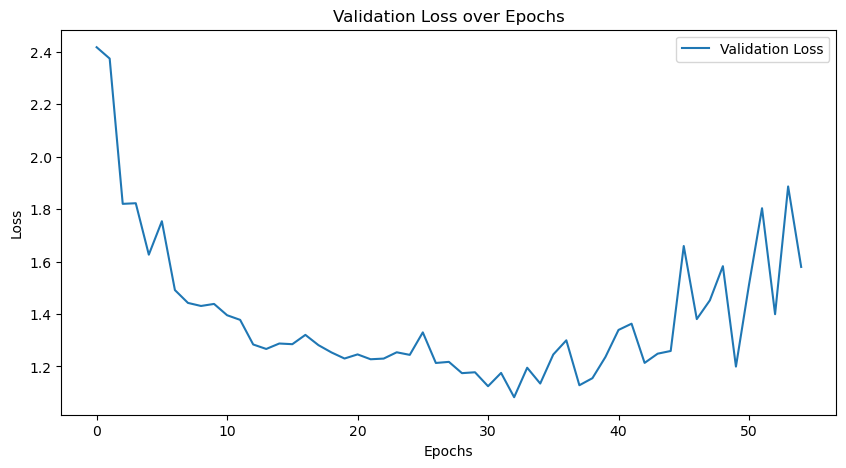

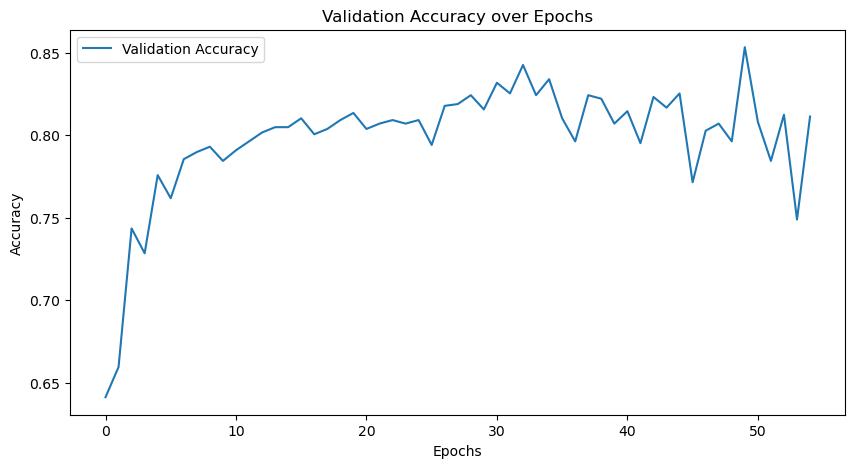

Validation loss: 1.5867030620574951
Validation accuracy: 0.806034505367279
Test loss: 0.37453219294548035
Test accuracy: 0.0


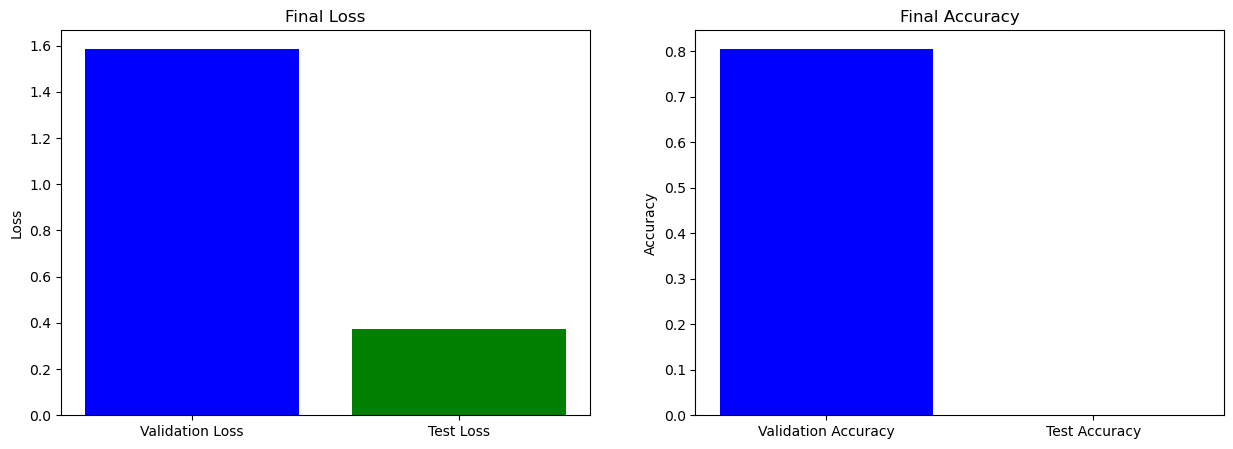

In [47]:
import matplotlib.pyplot as plt

# Extraer las métricas de los historiales de entrenamiento
val_loss_history = []
val_accuracy_history = []

for history in histories_adam50:
    val_loss_history.extend(history.history['val_loss'])
    val_accuracy_history.extend(history.history['val_accuracy'])

# Gráfica de la pérdida de validación
plt.figure(figsize=(10, 5))
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

# Gráfica de la precisión de validación
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Resultados finales de evaluación
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

# Gráfica comparativa de las métricas finales
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida final
ax[0].bar(['Validation Loss', 'Test Loss'], [val_loss, test_loss], color=['blue', 'green'])
ax[0].set_title('Final Loss')
ax[0].set_ylabel('Loss')

# Precisión final
ax[1].bar(['Validation Accuracy', 'Test Accuracy'], [val_accuracy, test_accuracy], color=['blue', 'green'])
ax[1].set_title('Final Accuracy')
ax[1].set_ylabel('Accuracy')

plt.show()


In [ ]:
import tensorflow as tf

class AdaptiveLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.01, factor=0.1, min_lr=1e-6):
        super(AdaptiveLearningRateScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.factor = factor
        self.min_lr = min_lr
        self.last_val_acc = 0
        self.lr = initial_lr
        self.epoch_accuracy = []
        self.learning_rates = [initial_lr]

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None:
            self.epoch_accuracy.append(current_val_acc)
            if current_val_acc < self.last_val_acc:
                if self.lr > self.min_lr:
                    self.lr = max(self.lr * self.factor, self.min_lr)
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
                    print(f"\nEpoch {epoch+1}: reducing learning rate to {self.lr}.")
            self.learning_rates.append(self.lr)
        else:
            self.learning_rates.append(self.lr)
            
        self.last_val_acc = current_val_acc
        print(f"\nEpoch {epoch+1}: Learning rate is {self.lr}.")

# Crear una instància del callback
adaptive_lr_scheduler = AdaptiveLearningRateScheduler()


## wandb

In [27]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_pooling"
    # track hyperparameters and run metadata with wandb.config
    # config={
    #     "layer_1": 512,
    #     "activation_1": "softmax", # relu
    #     "dropout": random.uniform(0.01, 0.80),
    #     "layer_2": 10,
    #     # "activation_2": "softmax",
    #     "optimizer": "adam",
    #     "loss": "sparse_categorical_crossentropy",
    #     "metric": "accuracy",
    #     "epoch": 8,
    #     "batch_size": 256,
    # },
)

# [optional] use wandb.config as your config
# config = run.config


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [39]:
histories_adam = model_adam.fit(
    x=train_gens[0],
    epochs=40,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10),
        adaptive_lr_scheduler
    ],
)


Epoch 1/20


c:\Users\jesus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
wandb: ERROR Unable to log learning rate.


17/99 ━━━━━━━━━━━━━━━━━━━━ 59s 730ms/step - accuracy: 0.1283 - loss: 2.4312 

KeyboardInterrupt: 

In [93]:
run.finish()

batch/accuracy,▁▂▅▆▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇█▇█▇█▇█▇
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▅▅▅▆▆▆▆▆▆▇▇▇▅▅█▇█▆
epoch/val_loss,█▆▃▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▁
batch/accuracy,0.90571


In [26]:
len(train_gens)

1

In [35]:
DIR_EPOCHS

1

In [36]:
MAX_EPOCHS

8

In [39]:
histories_adam50 = []
MAX_EPOCHS=20
e = 0
while e < MAX_EPOCHS:
    for i in range(len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n // train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n // valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN", STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID", STEP_SIZE_VALID)
        
        history = model_adam.fit(
            train_gens[i],
            steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_gens[i],
            validation_steps=STEP_SIZE_VALID,
            epochs=DIR_EPOCHS,
            callbacks=[adaptive_lr_scheduler]  
        )
        histories_adam50.append(history)
    e += 1


STEP_SIZE_TRAIN 98
STEP_SIZE_VALID 32
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3306 - loss: 3.3638
Epoch 1: Learning rate is 0.01.
98/98 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - accuracy: 0.3305 - loss: 3.3633 - val_accuracy: 0.1725 - val_loss: 1054.6271
STEP_SIZE_TRAIN 98
STEP_SIZE_VALID 32
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3722 - loss: 2.9725

AttributeError: 'str' object has no attribute 'name'

# Evaluate the model 🧐 🤔

In [56]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam2:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

## Plots
### Accuracies

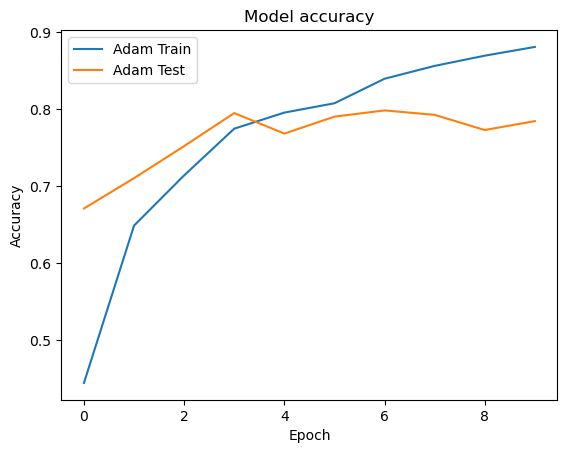

In [57]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [63]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_acc_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Loss values

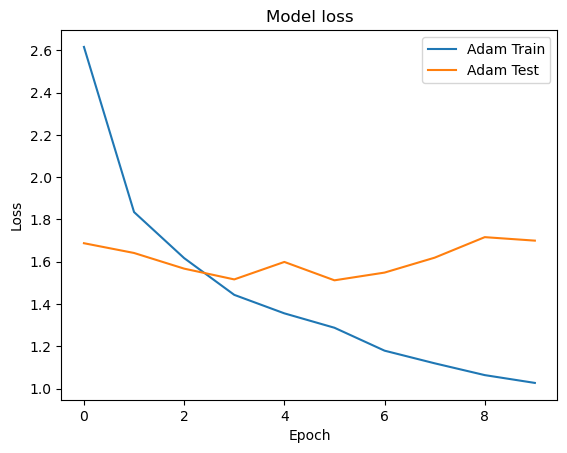

In [58]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [65]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_loss_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

# Predict the output 🔮 🎩

In [33]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)
PRED_STEPS

314

In [34]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.to_numpy()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

In [35]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artists")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artists")
    print("unexpected_match", unexpected_match)
    print("unexpected_count", unexpected_count)
    
    if unexpected_count != 0:
        u_acc = unexpected_match/unexpected_count
        print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

## Adam

In [37]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

OSError: image file is truncated (0 bytes not processed)

In [85]:
print(len(pred_adam),"\n",pred_adam)

10113 
 [[8.04727257e-04 4.04767739e-03 3.89879569e-04 ... 5.35861496e-03
  2.05516844e-05 8.24720628e-05]
 [1.09930761e-05 7.13876216e-04 1.25340803e-03 ... 9.94388130e-04
  3.79198559e-06 2.49061541e-05]
 [1.51381202e-04 8.74841469e-04 3.75820309e-05 ... 6.74502342e-04
  4.13899579e-06 4.49073195e-05]
 ...
 [1.39237553e-01 1.04452565e-01 7.60575582e-04 ... 7.46746222e-03
  5.34233376e-02 2.08907411e-03]
 [1.77956317e-04 6.74847901e-01 6.08954020e-02 ... 8.75055033e-04
  1.24265872e-01 2.19740643e-04]
 [4.03708927e-02 1.24865668e-02 5.25613362e-03 ... 1.17507484e-02
  2.11067483e-01 1.39211980e-03]]


In [86]:
predicted_class_indices_adam=np.argmax(pred_adam,axis=1)

In [87]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

10113 
 [4 4 4 ... 5 1 5]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 10113 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


In [88]:
results_adam.head()

,Filename,Predictions,Real Values
0,32145.jpg,Pablo Picasso,kiri nichol
1,20304.jpg,Pablo Picasso,kiri nichol
2,836.jpg,Pablo Picasso,kiri nichol
3,49823.jpg,Pablo Picasso,Hiroshige
4,84512.jpg,John Singer Sargent,Franz Richard Unterberger


In [89]:
len(training_set_artists)

10

In [90]:
print(training_set_artists)

['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [92]:
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists


ZeroDivisionError: division by zero

## SGD

In [73]:
test_gen.reset()
pred_sgd = model_sgd.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_sgd),"\n",pred_sgd)

  5/281 [..............................] - ETA: 33:23

KeyboardInterrupt: 

In [62]:
predicted_class_indices_sgd = np.argmax(pred_sgd,axis=1)

In [63]:
results_sgd = retrieve_results(predicted_class_indices_sgd, train_gens)
results_sgd.head()

7025 
 [4 3 2 ... 3 1 3]
it has values ranging from  0 ...to... 9
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Pierre-Auguste Renoir,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,Ivan Shishkin,Jan Matejko


In [64]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [65]:
testing_new_images(results_sgd, training_set_artists)

test accuracy on new images for TRAINED artists
227 / 335 = 0.6776
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
227 / 7025 = 0.0323


## RMSprop

In [66]:
test_gen.reset()
pred_RMS = model_RMS.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_RMS),"\n",pred_RMS)

281/281 [==============================] - 194s 655ms/step
7025 
 [[2.1443799e-02 2.7314452e-03 1.9525861e-03 ... 7.1664699e-06
  7.4858626e-04 1.2445415e-03]
 [1.7144992e-04 4.5708535e-04 4.1855793e-07 ... 1.9475513e-06
  8.5016536e-03 8.8260066e-07]
 [1.5640775e-03 3.2066507e-03 8.0450183e-01 ... 5.2702957e-04
  6.6229612e-02 1.8388973e-06]
 ...
 [6.5013796e-02 1.3065257e-03 2.0052115e-05 ... 5.2633203e-07
  1.7853242e-01 1.7775544e-07]
 [5.2264878e-03 6.4723516e-01 5.4563824e-02 ... 3.0369400e-03
  1.5838053e-02 4.9470534e-04]
 [5.6721634e-05 4.6246450e-02 6.1807758e-03 ... 6.9209425e-05
  7.8524435e-03 2.4185749e-05]]


In [67]:
predicted_class_indices_RMS = np.argmax(pred_RMS,axis=1)

In [68]:
results_RMS = retrieve_results(predicted_class_indices_RMS, train_gens)
results_RMS.head()

7025 
 [4 3 2 ... 3 1 3]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Pierre-Auguste Renoir,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,John Singer Sargent,Jan Matejko


In [85]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [69]:
testing_new_images(results_RMS, training_set_artists)

test accuracy on new images for TRAINED artists
231 / 335 = 0.6896
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
231 / 7025 = 0.0329


# Ideas
- Having a the prediction dataset: Filename, Predictions, Real Values. We can construct a composition of the predictions.
- We can now predict artist and another caracteristic (like stryle).

## Mosaics

In [95]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)


### Predictions

In [97]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/compositions/predictions_13000_images/composition_{}.png'.format(predicted_artist))


### Real values

In [104]:
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

In [105]:

grouped_data

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
filtered_data = results_adam[results_adam['Real Values'].isin(training_set_artists)]
grouped_data = filtered_data.groupby('Real Values')# tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/XNAPproject-grup07/compostions/real_values_13000_images/composition_{}.png'.format(predicted_artist))


Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/service/server_sock.py", line 99, in run
    sreq = self._sock_client.read_server_request()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 274, in read_server_request
    data = self._read_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 248, in _read_packet_bytes
    rec = self._extract_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 230, in _extract_packet_bytes
    assert magic == ord("W")
AssertionError
Bad pipe message: %s [b'\xd2\xe9\xa0\xf1I\xb7}r\xe0\x7f\xc0\x83\xc1\xa2A\xa6\xeb\x8e P\xa0f\xb6\xd3\x198\x0e\x8e\xcag\xf0', b'\x19a\x03u\xba\xbe\xfb\x